# Python Script to get number of commits by user by month from and Azure DevOps Repo

- This is a good script for pulling back commit information to see how activity has increased over time on a repo

___

### Step One: Import Dependencies 

In [28]:
import requests
import pandas as pd
from datetime import datetime
from collections import defaultdict
import base64

### Step Two: Create Functions

In [46]:
# function to get ADO commits
def get_ado_commits(organization, project, repo_id, ado_pat):

    # encode pat
    pat_encoded = base64.b64encode(f":{ado_pat}".encode()).decode()

    # define headers
    headers = {
        'Content-Type': 'application/json',
        'Authorization': f'Basic {pat_encoded}'
        }


    url = f'https://dev.azure.com/{organization}/{project}/_apis/git/repositories/{repo_id}/commits?api-version=7.0'
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    return response.json()['value']

# Function to parse datetime
def parse_datetime(date_str):
    for fmt in ('%Y-%m-%dT%H:%M:%S.%fZ', '%Y-%m-%dT%H:%M:%SZ'):
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            pass
    raise ValueError(f"no valid date format found for {date_str}")

# function to process commit and output dataframe
def process_commit_to_df(commits_data, repo_id):

    # process commits to count by user by month
    commit_counts = defaultdict(lambda: defaultdict(int))

    for commit in commits_data:
        author = commit['author']['name']
        commit_date = parse_datetime(commit['author']['date'])
        month = commit_date.strftime('%Y-%m')
        commit_counts[author][month] += 1

    # Convert to a DataFrame for easier manipulation
    data = []

    for author, months in commit_counts.items():
        for month, count in months.items():
            data.append({'repo_name':repo_id, 'commiter_name': author, 'commit_month': month, 'commit_count_for_month': count})

    commit_df = pd.DataFrame(data)

    return commit_df

### Step Three: Define your Azure DevOps organization and project

In [53]:
ado_organization = "ado_organization_name"
ado_project = "ado_project"
ado_repo_id = "ado_repo_name"  # You can use the repository name or ID

### Step Four: Set your ADO PAT
- For info on creating an ADO PAT, go [here](https://learn.microsoft.com/en-us/azure/devops/organizations/accounts/use-personal-access-tokens-to-authenticate?view=azure-devops&tabs=Windows)

In [52]:
ado_pat = "your_ado_pat"

### Step Five: Run Everything

In [47]:
# get ADO commits
ado_commits = get_ado_commits(ado_organization, ado_project, ado_repo_id, ado_pat)

# convert into pandas df
commits_df = process_commit_to_df(ado_commits, ado_repo_id)

### Analyze Results

In [48]:
# display results as a Data Frame
display(commits_df)

,repo_name,commiter_name,commit_month,commit_count_for_month
0,sample_dbt_project,Steve Dowling,2024-08,1
1,sample_dbt_project,Steve Dowling,2022-08,52


In [49]:
# export to csv
commits_df.to_csv('./commit_counts_by_user_by_month.csv', index=False)

Matplotlib is building the font cache; this may take a moment.


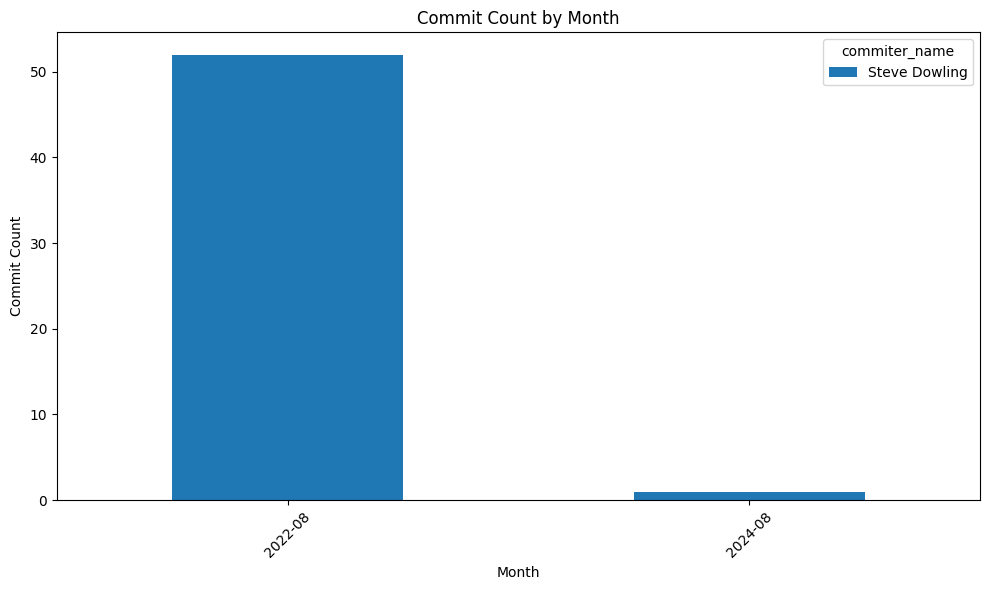

In [51]:
# [Overkill] display results as a Chart
import matplotlib.pyplot as plt

# Pivot the data for better visualization
pivot_df = commits_df.pivot(index='commit_month', columns='commiter_name', values='commit_count_for_month').fillna(0)

# Plotting
pivot_df.plot(kind='bar', figsize=(10, 6))

# Adding title and labels
plt.title('Commit Count by Month')
plt.xlabel('Month')
plt.ylabel('Commit Count')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

___

# END OF SCRIPT

___